In [25]:
import underworld as uw
import matplotlib as mpl
from matplotlib.figure import Figure
import matplotlib.pyplot as pyplot
import numpy as np
import math
import h5py
import glob
import UWGeodynamics as GEO
#from MechanicalProperties import PlateProperties
from pathlib import Path
import sys
import underworld.function as fn
#import glucifer
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.offsetbox import AnchoredText

In [26]:
def getColoursfromMap(cmapKey,NumColours):
    cmap = plt.get_cmap(cmapKey)
    norm = mcolors.Normalize(vmin=0, vmax=NumColours)
    #Base array to calculate the colors
    seedColors=np.arange(0,NumColours,1)
    colours=cmap(norm(seedColors))
    return colours

def genStdColorArray(Thicknesses,colors,colorflip):
    iColor=0
    limitThick=colorflip[1]
    plotCounter=0
    #Get Colors and put them into an array
    ColorsS=[]
    colorC=0
    for j in colors:
        ColorsS.append(getColoursfromMap(colors[colorC],len(Thicknesses)))
        colorC=colorC+1
    counter=0
    #array which will contain colors to return    
    FinalColours=[]
    
    for i in Thicknesses:
        #Color changes
        if colorflip[0]==True:
            if limitThick> i:
                Colors=ColorsS[0]
            elif limitThick<=i:
                Colors=ColorsS[1]    
            else:
                Colors=ColorsS[0]     
        color=Colors[counter]
        FinalColours.append(color)
        counter=counter+1
    return FinalColours

def loadViscousDissTime_Thicknesses(DataDir,thickness,fileSeed,areaType):
    fileName=DataDir+fileSeed+"{0}km.txt".format(str(thickness))
    Data = np.genfromtxt(fileName, dtype=float)
    if areaType=="whole":
        t,VisDiss=Data[:,0],Data[:,1]
    elif areaType=="Lithosphere":
        t,VisDiss=Data[:,0],Data[:,2]
    elif areaType=="Mantle":
        t,VisDiss=Data[:,0],Data[:,3]
    return t,VisDiss

def velocitiesLoader(DataDir,thickness,typePlot,fileSeed):
    fileName=DataDir+fileSeed+"{0}.txt".format(str(thickness))
    Data = np.genfromtxt(fileName, dtype=float,skip_footer=1)
    v_sp=Data[:,1]
    v_op=-Data[:,3]
    v_t=-(Data[:,2]+Data[:,3])
    #v_t2=-Data[:,4]
    #Independent from reference frame
    Vc=v_op+v_sp
    Vs=v_t+v_sp
    
    if typePlot=="subduction_velocity":
        t,vel=Data[:,0],v_sp
    elif typePlot=="Trench_retreat_vel":
        t,vel=Data[:,0],v_t
    elif typePlot=="OP_retreat_vel":
        t,vel=Data[:,0],v_op
    elif typePlot=="Arc_retreat_vel":
        t,vel=Data[:,0],v_t2
    elif typePlot=="OPDefRate": #overriding plate deformation rate
        t,vel=Data[:,0],v_t-v_op
    elif typePlot=="Sub_vel": #Actual subduction velocity?
        t,vel=Data[:,0],v_t+v_sp
    elif typePlot=="Conver_vel":
        t,vel=Data[:,0], v_sp+v_op
    return t,vel

In [32]:
from matplotlib.offsetbox import AnchoredText
#Time_array,SPVel,OPVel,arcVel,cratVel,Xlabel,figsize,Thicknesses,thicknessLabel,Colors
def plotIntegratedDiss_allTimesSingle_vel(seed1,seed2,thicknesses,Colors,figsize):
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    #PLots to include in the subplots
    Nplots=2
    areaTypes=["Lithosphere","whole"]#,"Mantle"]
    labelTitles=["Lithosphere","Whole domain","Asthenosphere"]
    markers=["","",""]
    #markers=["v","+","^"]
    lineStyles=["-","-"]
    #Figure parameters
    fig, axs = pyplot.subplots(3,1,figsize=figsize,sharex=True)
    Max=0
    Min=0
    ax=axs[1]
    ax1=axs[2]
    plotCounter=0
    for j in areaTypes:
        seed=axs[plotCounter+1]
        counter=0
        for i in thicknesses:
            t,intVDiss=loadViscousDissTime_Thicknesses("/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Viscous_dissipation_data/",i,"ViscousDissipation_",j)
            #plot parameters
            seed.set_ylabel("Viscous Dissipation (W/m)",labelpad=2,fontsize=8)
            if i==0:
                colour='black'
            else:
                colour=Colors[counter]
            #plot data
            line1,=seed.plot(t,intVDiss/1e4,linewidth=0.7,color=colour,marker=markers[plotCounter],
                      markersize=3.0,markevery=5,linestyle=lineStyles[plotCounter])
            seed.set_xlim(0,50)
            seed.tick_params(axis = 'both', which = 'major', labelsize = 8)
            Max=(max(intVDiss))/1e4
            counter=counter+1
        seed.set_xlabel("Time (Ma)",labelpad=2,fontsize=8)
        seed.set_ylim(0,Max+Max*1/6)
        seed.axvline(x=16,ymin=Min+1/3*Min,ymax=Max+2*Max,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
        seed.axvline(x=22.5,ymin=Min+1/3*Min,ymax=Max+2*Max,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
        seed.axvline(x=34,ymin=Min+1/3*Min,ymax=Max+2*Max,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
        adjustX=(0+50)/10.
        arrangeTicksX=np.arange(0,51,adjustX)
        seed.xaxis.set_ticks(arrangeTicksX)
        plotCounter=plotCounter+1
    
    #Velocity axis settings
    typePlots=["Sub_vel","Trench_retreat_vel","OP_retreat_vel","Arc_retreat_vel"]
    names=["Subduction velocity","Trench-retreat velocity vs Time","OP retreat velocity vs Time","Arc retreat velocity vs Time"]
    
    counter=0
    Max=0
    Min=0
    #Loop for iterating thicknesses
    for i in thicknesses:
        seed=axs[0]
        plotType=typePlots[0]
        #Have to replace this line for the loading function..
        t,vel=velocitiesLoader('/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Kinematics_data/',i,plotType,"platesVelocities_")
        if i==0:
            colour='black'
        else:
            colour=Colors[counter]
        seed.plot(t,vel,label='{0} Km'.format((eval(str(i)))),linewidth=0.7,color=colour)
        seed.set_ylabel("Velocity (cm/yr)",labelpad=2,fontsize=8)
        if plotType=="OPDefRate":
            seed.set_ylabel(r"$V_{OPD}$"+" (cm/yr)",labelpad=2,fontsize=8)
            #pyplot.yscale('symlog')
            seed.set_ylim((1.22*Min),Max*2.98)
            a=1
        elif plotType=="Sub_vel":
            seed.set_ylabel(r"$V_{S}$"+" (cm/yr)",labelpad=2,fontsize=8)
        #seed.legend(fontsize=int(8.5),fancybox=True)
        seed.tick_params(axis = 'both', which = 'major', labelsize =8) 
        seed.set_xlim(0,45)
        #seed.yaxis.set_major_locator(mpl.ticker.LinearLocator(5))
        Max=max(vel)
        Min=min(vel)
        seed.set_ylim((1.52*Min),Max*1.78) #1.541
        counter=counter+1
           
    counter=counter-1
    seed.set_xlabel("Time (Ma)",labelpad=2,fontsize=8)
    seed.axhline(y=0, xmin=0, xmax=max(t)+max(t)/6.,color='black',linestyle='--',linewidth=0.7,alpha=0.4)
    seed.axvline(x=16,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
    seed.axvline(x=22.5,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
    seed.axvline(x=34,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
    
            
    adjustX=(0+45)/9.
    #Arrange ticks Array
    arrangeTicksX=np.arange(0,46,adjustX)
    #Ticks Change
    seed.xaxis.set_ticks(arrangeTicksX)
    #plotCounter=plotCounter+1    
    fig.tight_layout(pad=1.,h_pad=0.08,w_pad=0.4)
    pyplot.subplots_adjust(wspace=0, hspace=0)
    #pyplot.subplots_adjust(wspace=0, hspace=0)
    %matplotlib
    return fig

In [33]:
saveDir='/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Raw_PDFs/'

## Viscouss Dissipation evolution vs time

In [34]:
#Model parameters and directories
dimensions = ([-1800.,-800.],[1800.,0.])
outres = (1500,300) #Output image resolution
xRes,yRes = 296,160 #Grid/mesh resolution
seed1="outputs_MechanicalTransference_BenchmarkFinal_"
seed2="kmArc_80Ma_DruckerPrager_WLM"
#gravity=9.81*u.meter/u.second**2
#Uniform Color scale for all plots of GPE - deltaStress
ColorsPlots=genStdColorArray([0,15,16,17,18,19,20,21,22,23,24,25,32,33,34,35],["Blues_r","Reds"],[True, 32.])
#15,20,23,25,30,32,33,35

Using matplotlib backend: agg


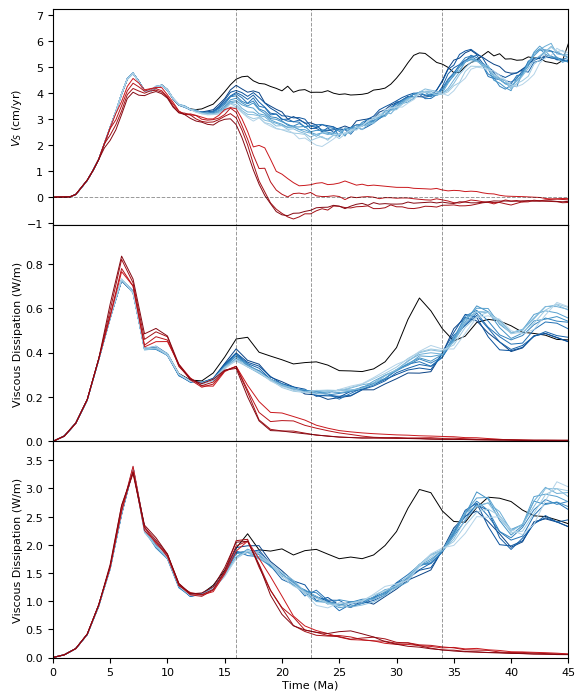

In [35]:
fig=plotIntegratedDiss_allTimesSingle_vel(seed1,seed2,[0,15,16,17,18,19,20,21,22,23,24,25,32,33,34,35],ColorsPlots,(15/2.54, 18/2.54))
fig

In [36]:
fig.savefig(saveDir+'/Fig_7_raw.pdf')